In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch import tensor, float32, no_grad, save, sigmoid
from torch.optim import Adam
from torch.nn import Module, LSTM, Linear, MSELoss, BCELoss
from torch.nn.init import constant_, xavier_normal_
from torch.nn.utils import clip_grad_norm_

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from datetime import datetime
from glob import glob
from torch.utils.data import DataLoader, TensorDataset
import os
import json

In [3]:
class StockPredictor(Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(StockPredictor, self).__init__()
        self.lstm = LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.5)
        self.linear = Linear(hidden_dim, 3)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = sigmoid(self.linear(out[:, -1, :]))
        return out
    
def calculate_accuracy(y_pred, y_actual):
    y_pred_bin = (y_pred >= 0.5).float()
    correct_predictions = (y_pred_bin == y_actual).sum(dim=0)
    # correct_predictions2 = (y_pred_bin == y_actual)#.sum(dim=0)
    # print(f'accuracy calculation: corr: {correct_predictions}')
    # print(f'accuracy calculation: corr2: {correct_predictions2}')
    accuracy = correct_predictions / y_actual.size(0)
    return accuracy.tolist()

def evaluate_threshold(actual, predicted, threshold):
    predicted_tensor = tensor(predicted)
    predicted_labels = (predicted_tensor > threshold).int().tolist()
    correct = sum([1 for act, pred in zip(actual, predicted_labels) if act == pred])
    accuracy = correct / len(actual)
    return accuracy

def compute_metrics_for_threshold(all_actual, all_predictions, threshold):
    actual_ones = [0, 0, 0]
    actual_zeros = [0, 0, 0]
    predicted_ones = [0, 0, 0]
    predicted_zeros = [0, 0, 0]
    false_positives = [0, 0, 0]
    false_negatives = [0, 0, 0]

    for actual_values, predicted_values in zip(all_actual, all_predictions):
        for idx, (actual, predicted) in enumerate(zip(actual_values, predicted_values)):
            if actual == 1:
                actual_ones[idx] += 1
                if predicted < threshold:
                    false_negatives[idx] += 1
            else:
                actual_zeros[idx] += 1
                if predicted >= threshold:
                    false_positives[idx] += 1

            if predicted >= threshold:
                predicted_ones[idx] += 1
            else:
                predicted_zeros[idx] += 1

    metrics = {
        "actual_ones": actual_ones,
        "actual_zeros": actual_zeros,
        "predicted_ones": predicted_ones,
        "predicted_zeros": predicted_zeros,
        "false_positives": false_positives,
        "false_negatives": false_negatives
    }
    return metrics

def check_timestamp(ts):
    return len(str(ts)) == 13


In [4]:
TIME_DIFF_1 = 1
TIME_DIFF_24 = 24 # a day
TIME_DIFF_168 = 24 * 7 # a week
    
targets = [
    f"Target_shifted_{TIME_DIFF_1}",
    f"Target_shifted_{TIME_DIFF_24}",
    f"Target_shifted_{TIME_DIFF_168}"
]

file_idx = 12
num_epochs = 10
all_predictions = []
all_actual = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
# target_feature = "Target"
features = ['Volume USD', 'SMA', 'EMA', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'VWAP', 'Percentage_Returns', 'Log_Returns']
seq_length = 100
X, y = [], []
model = StockPredictor(input_dim=len(features), hidden_dim=50, num_layers=2)
# model = StockPredictor(input_dim=len(features), hidden_dim=50, num_layers=2)
criterion = BCELoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()

file_paths = glob('modified_data/gemini_data_*')
file_paths.sort()



In [5]:
print(f'Opening file: {file_paths[file_idx]}')
data = pd.read_csv(file_paths[file_idx])
data = data.dropna()

all_columns = features + targets
prices = data[all_columns].values

Opening file: modified_data/gemini_data_BOND_mod.csv


In [6]:

X, y = [], []
scaler.fit(data[features].values)

# for i in range(len(prices) - seq_length):
#     X.append(prices[i:i+seq_length])
#     y.append(prices[i+seq_length, features.index(target_feature)]) # We want to predict the target_feature value

for i in range(len(prices) - seq_length):
    X.append(prices[i:i+seq_length, :len(features)])
    y_values = [prices[i+seq_length, len(features)+target_idx] for target_idx in range(len(targets))]
    y.append(y_values)

X = np.array(X)
y = np.array(y)

split_idx = int(len(X) * 0.8) # 80% for training
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
# Scaling the data
X_train_2D = X_train.reshape(-1, X_train.shape[-1])
X_test_2D = X_test.reshape(-1, X_test.shape[-1])

# Scale the data
X_train_scaled_2D = scaler.transform(X_train_2D)
X_test_scaled_2D = scaler.transform(X_test_2D)

# Reshape the data back to 3D
X_train = X_train_scaled_2D.reshape(X_train.shape)
X_test = X_test_scaled_2D.reshape(X_test.shape)

X_train = tensor(X_train, dtype=float32)
y_train = tensor(y_train, dtype=float32).reshape(-1, 3)
X_test = tensor(X_test, dtype=float32)
y_test = tensor(y_test, dtype=float32).reshape(-1, 3)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:

for name, param in model.named_parameters():
    if 'bias' in name:
        constant_(param, 0.0)
    elif 'weight' in name:
        xavier_normal_(param)

for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        train_acc = calculate_accuracy(outputs, y_batch)
        train_accuracies.append(train_acc)

    model.eval()
    test_loss = 0
    with no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predicted_probs = outputs.tolist()  # Store the raw probability
            all_predictions.extend(predicted_probs)
            all_actual.extend(y_batch.tolist())
            test_loss += criterion(outputs, y_batch).item()
            test_acc = calculate_accuracy(outputs, y_batch)
            test_accuracies.append(test_acc)


    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))

    print(f"{datetime.now()}: Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")


2023-10-05 10:56:06.810006: Epoch 1/10, Train Loss: 0.6911, Test Loss: 0.6882
2023-10-05 10:56:28.700303: Epoch 2/10, Train Loss: 0.6859, Test Loss: 0.6842
2023-10-05 10:56:49.975382: Epoch 3/10, Train Loss: 0.6814, Test Loss: 0.6971
2023-10-05 10:57:13.140129: Epoch 4/10, Train Loss: 0.6734, Test Loss: 0.7950
2023-10-05 10:57:27.898152: Epoch 5/10, Train Loss: 0.6769, Test Loss: 1.2340
2023-10-05 10:57:44.392247: Epoch 6/10, Train Loss: 0.6757, Test Loss: 0.7113
2023-10-05 10:58:01.731386: Epoch 7/10, Train Loss: 0.6707, Test Loss: 0.7491
2023-10-05 10:58:19.558646: Epoch 8/10, Train Loss: 0.6646, Test Loss: 0.7642
2023-10-05 10:58:35.078542: Epoch 9/10, Train Loss: 0.6636, Test Loss: 0.7386
2023-10-05 10:58:50.121806: Epoch 10/10, Train Loss: 0.6613, Test Loss: 0.7956


In [8]:

thresholds = np.linspace(0, 1, 101)
for thresh in thresholds:
    accuracy = evaluate_threshold(all_actual, all_predictions, thresh)
    print(f"Accuracy for threshold {thresh}: {accuracy:.4f}")

targets = ["1 hour", "24 hours", "168 hours"]
evaluation_metrics_by_threshold = []

for thresh in thresholds:
    print(f"\nMetrics for threshold {thresh}:")
    metrics = compute_metrics_for_threshold(all_actual, all_predictions, thresh)

    metrics_for_threshold = {
        "Threshold": thresh
    }
    for i, target in enumerate(targets):
        print(f"Metrics for prediction over {target}:")
        print(f"Actual 1s: {metrics['actual_ones'][i]}")
        print(f"Actual 0s: {metrics['actual_zeros'][i]}")
        print(f"Predicted 1s: {metrics['predicted_ones'][i]}")
        print(f"Predicted 0s: {metrics['predicted_zeros'][i]}")
        print(f"False Positives: {metrics['false_positives'][i]}")
        print(f"False Negatives: {metrics['false_negatives'][i]}")
        print(f"False Positive Ratio: {metrics['false_positives'][i] / (metrics['actual_zeros'][i]):.4f}")
        print(f"False Negative Ratio: {metrics['false_negatives'][i] / (metrics['actual_ones'][i]):.4f}")
        print("------\n")
        # Storing metrics for this target
        metrics_for_threshold[target] = {
            "Actual 1s": metrics['actual_ones'][i],
            "Actual 0s": metrics['actual_zeros'][i],
            "Predicted 1s": metrics['predicted_ones'][i],
            "Predicted 0s": metrics['predicted_zeros'][i],
            "False Positives": metrics['false_positives'][i],
            "False Negatives": metrics['false_negatives'][i],
            "False Positive Ratio": metrics['false_positives'][i] / (metrics['actual_zeros'][i]),
            "False Negative Ratio": metrics['false_negatives'][i] / (metrics['actual_ones'][i])
        }

    evaluation_metrics_by_threshold.append(metrics_for_threshold)



Accuracy for threshold 0.0: 0.2732
Accuracy for threshold 0.01: 0.2732
Accuracy for threshold 0.02: 0.2737
Accuracy for threshold 0.03: 0.2628
Accuracy for threshold 0.04: 0.2607
Accuracy for threshold 0.05: 0.2597
Accuracy for threshold 0.06: 0.2580
Accuracy for threshold 0.07: 0.2571
Accuracy for threshold 0.08: 0.2558
Accuracy for threshold 0.09: 0.2543
Accuracy for threshold 0.1: 0.2530
Accuracy for threshold 0.11: 0.2528
Accuracy for threshold 0.12: 0.2519
Accuracy for threshold 0.13: 0.2518
Accuracy for threshold 0.14: 0.2515
Accuracy for threshold 0.15: 0.2514
Accuracy for threshold 0.16: 0.2522
Accuracy for threshold 0.17: 0.2523
Accuracy for threshold 0.18: 0.2521
Accuracy for threshold 0.19: 0.2512
Accuracy for threshold 0.2: 0.2508
Accuracy for threshold 0.21: 0.2504
Accuracy for threshold 0.22: 0.2501
Accuracy for threshold 0.23: 0.2496
Accuracy for threshold 0.24: 0.2492
Accuracy for threshold 0.25: 0.2490
Accuracy for threshold 0.26: 0.2487
Accuracy for threshold 0.27: 0.

In [9]:

# Converting milliseconds to seconds
data['unix'] = data['unix'].apply(lambda x: x//1000 if check_timestamp(x) else x)
data['date'] = pd.to_datetime(data['unix'], unit='s')
dates = data['date'][seq_length:].values  # Removing first 'seq_length' rows as they are used for features and won't have a corresponding y value

if not os.path.exists('results'):
    os.makedirs('results')

# Save to a file
current_time = datetime.now().strftime('%Y%m%d_%H%M')
file_name = f"results/model_data_{current_time}.json"

model_data = {
    "Date of Training": current_time,
    "Training File": file_paths[file_idx],
    "Data Range": {"Start": pd.Timestamp(dates[0]).strftime('%Y-%m-%d'), "End": pd.Timestamp(dates[-1]).strftime('%Y-%m-%d')},
    "Features Used": features,
    "Targets": targets,
    "Model Structure": str(model),
    "Model Parameters": {
        "Hidden Dimension": model.lstm.hidden_size,
        "Number of Layers": model.lstm.num_layers,
        "Dropout Rate": model.lstm.dropout,
    },
    "Loss Function": str(criterion),
    "Optimizer": {
        "Type": "Adam",
        "Learning Rate": 0.001,
        "Weight Decay": 1e-5
    },
    "Epochs": num_epochs,
    "Train Loss Over Epochs": train_losses,
    "Test Loss Over Epochs": test_losses,
    "Evaluation Metrics": evaluation_metrics_by_threshold,
}


with open(file_name, 'w') as file:
    json.dump(model_data, file, indent=4)

print(f"Saved model data to {file_name}")

Saved model data to results/model_data_20231005_1104.json


In [10]:

# Given thresholds and evaluation_metrics_by_threshold from your code
# thresholds = [metrics["Threshold"] for metrics in evaluation_metrics_by_threshold]

# Extracting the data for each target
fp_ratios = {target: [] for target in targets}
fn_ratios = {target: [] for target in targets}
fp_counts = {target: [] for target in targets}
fn_counts = {target: [] for target in targets}

for metrics in evaluation_metrics_by_threshold:
    for target in targets:
        fp_ratios[target].append(metrics[target]['False Positive Ratio'])
        fn_ratios[target].append(metrics[target]['False Negative Ratio'])
        fp_counts[target].append(metrics[target]['False Positives'])
        fn_counts[target].append(metrics[target]['False Negatives'])



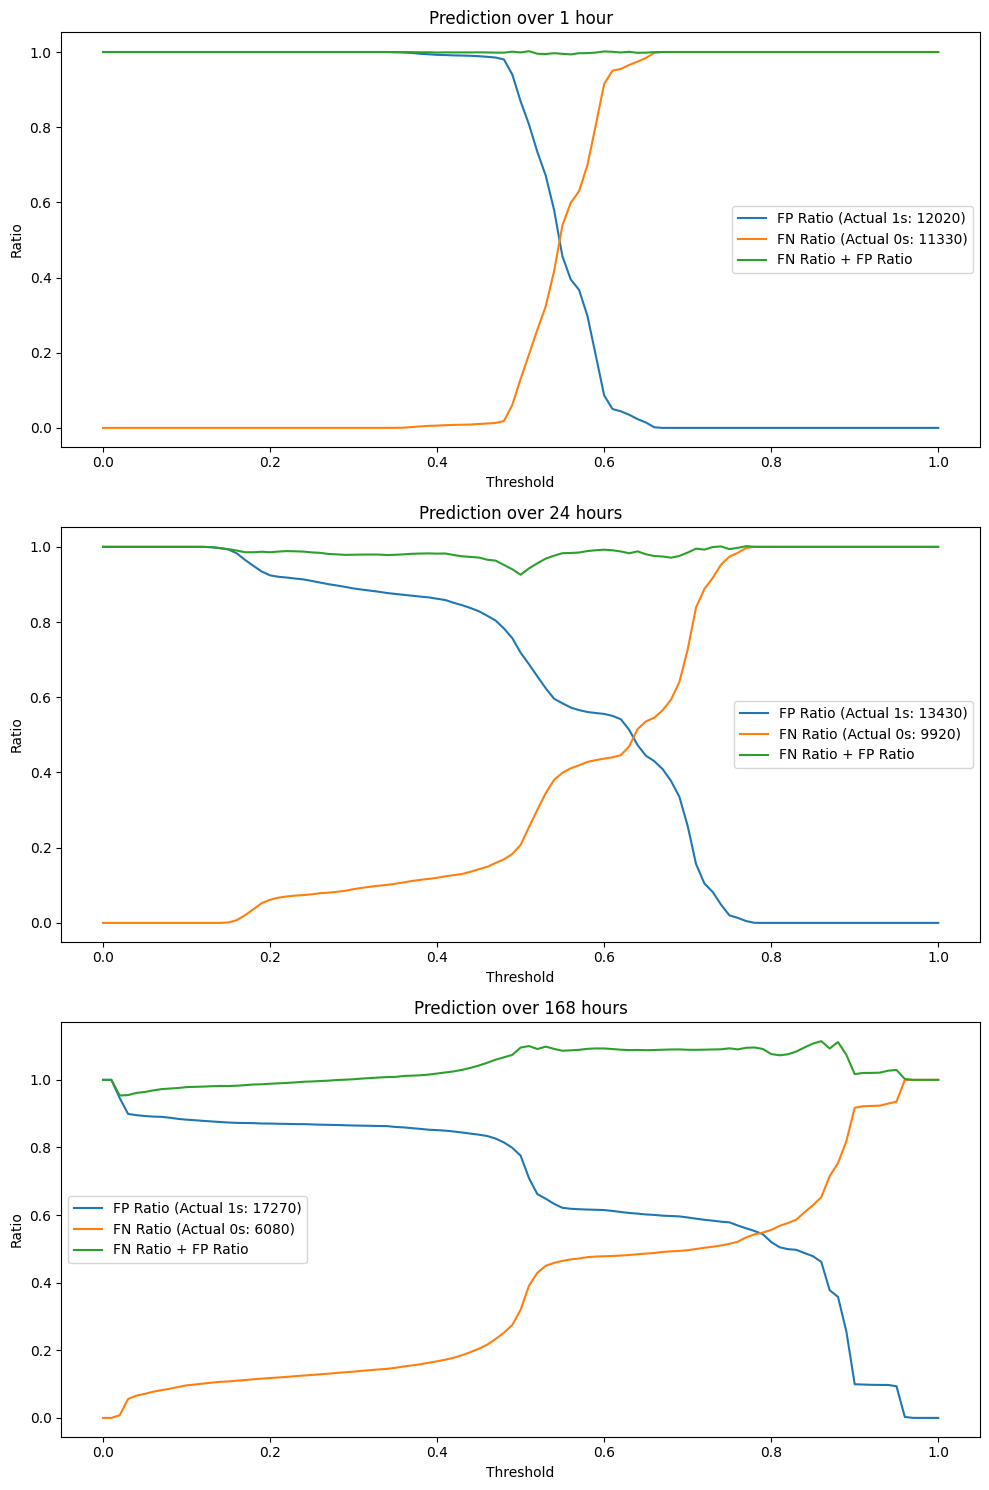

In [11]:
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for idx, (target, metrics) in enumerate(zip(targets, evaluation_metrics_by_threshold)):
    axs[idx].plot(thresholds, fp_ratios[target], label=f'FP Ratio (Actual 1s: {metrics[target]["Actual 1s"]})')
    axs[idx].plot(thresholds, fn_ratios[target], label=f'FN Ratio (Actual 0s: {metrics[target]["Actual 0s"]})')
    axs[idx].plot(thresholds, [a + b for a,b in zip(fn_ratios[target], fp_ratios[target])], label=f'FN Ratio + FP Ratio')
    
    axs[idx].set_title(f'Prediction over {target}')
    axs[idx].set_xlabel('Threshold')
    axs[idx].set_ylabel('Ratio')
    axs[idx].legend()

plt.tight_layout()

plt.savefig(f'results/plots/{current_time}_fp_fn.png')
plt.show()


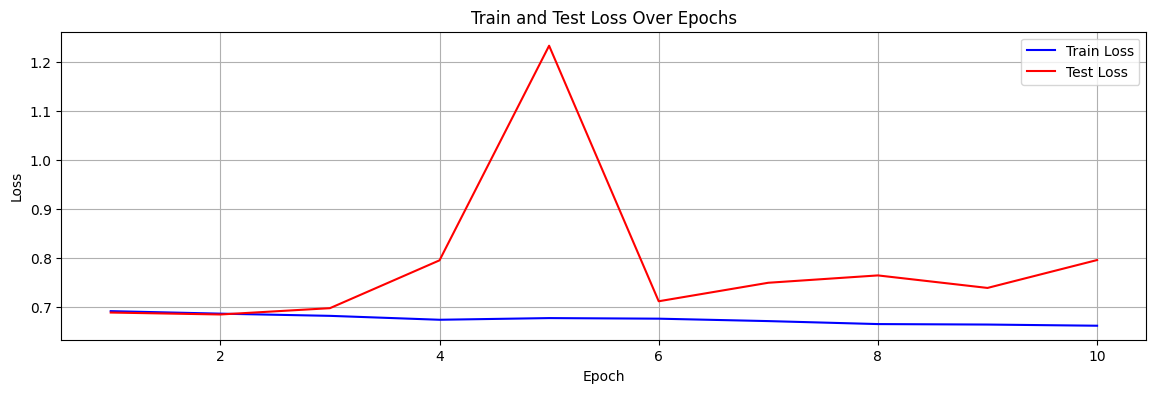

In [12]:

# 2. Display target and predicted values for "close" column over time
test_dates = dates[-len(y_test):]

# Repeating test dates for number of epochs
all_dates = np.tile(test_dates, num_epochs)

# 4. Plot train and test loss over prediction number
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(14, 4))
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.plot(epochs, test_losses, label="Test Loss", color="red")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.savefig(f'results/plots/{current_time}_losses.png')
plt.show()

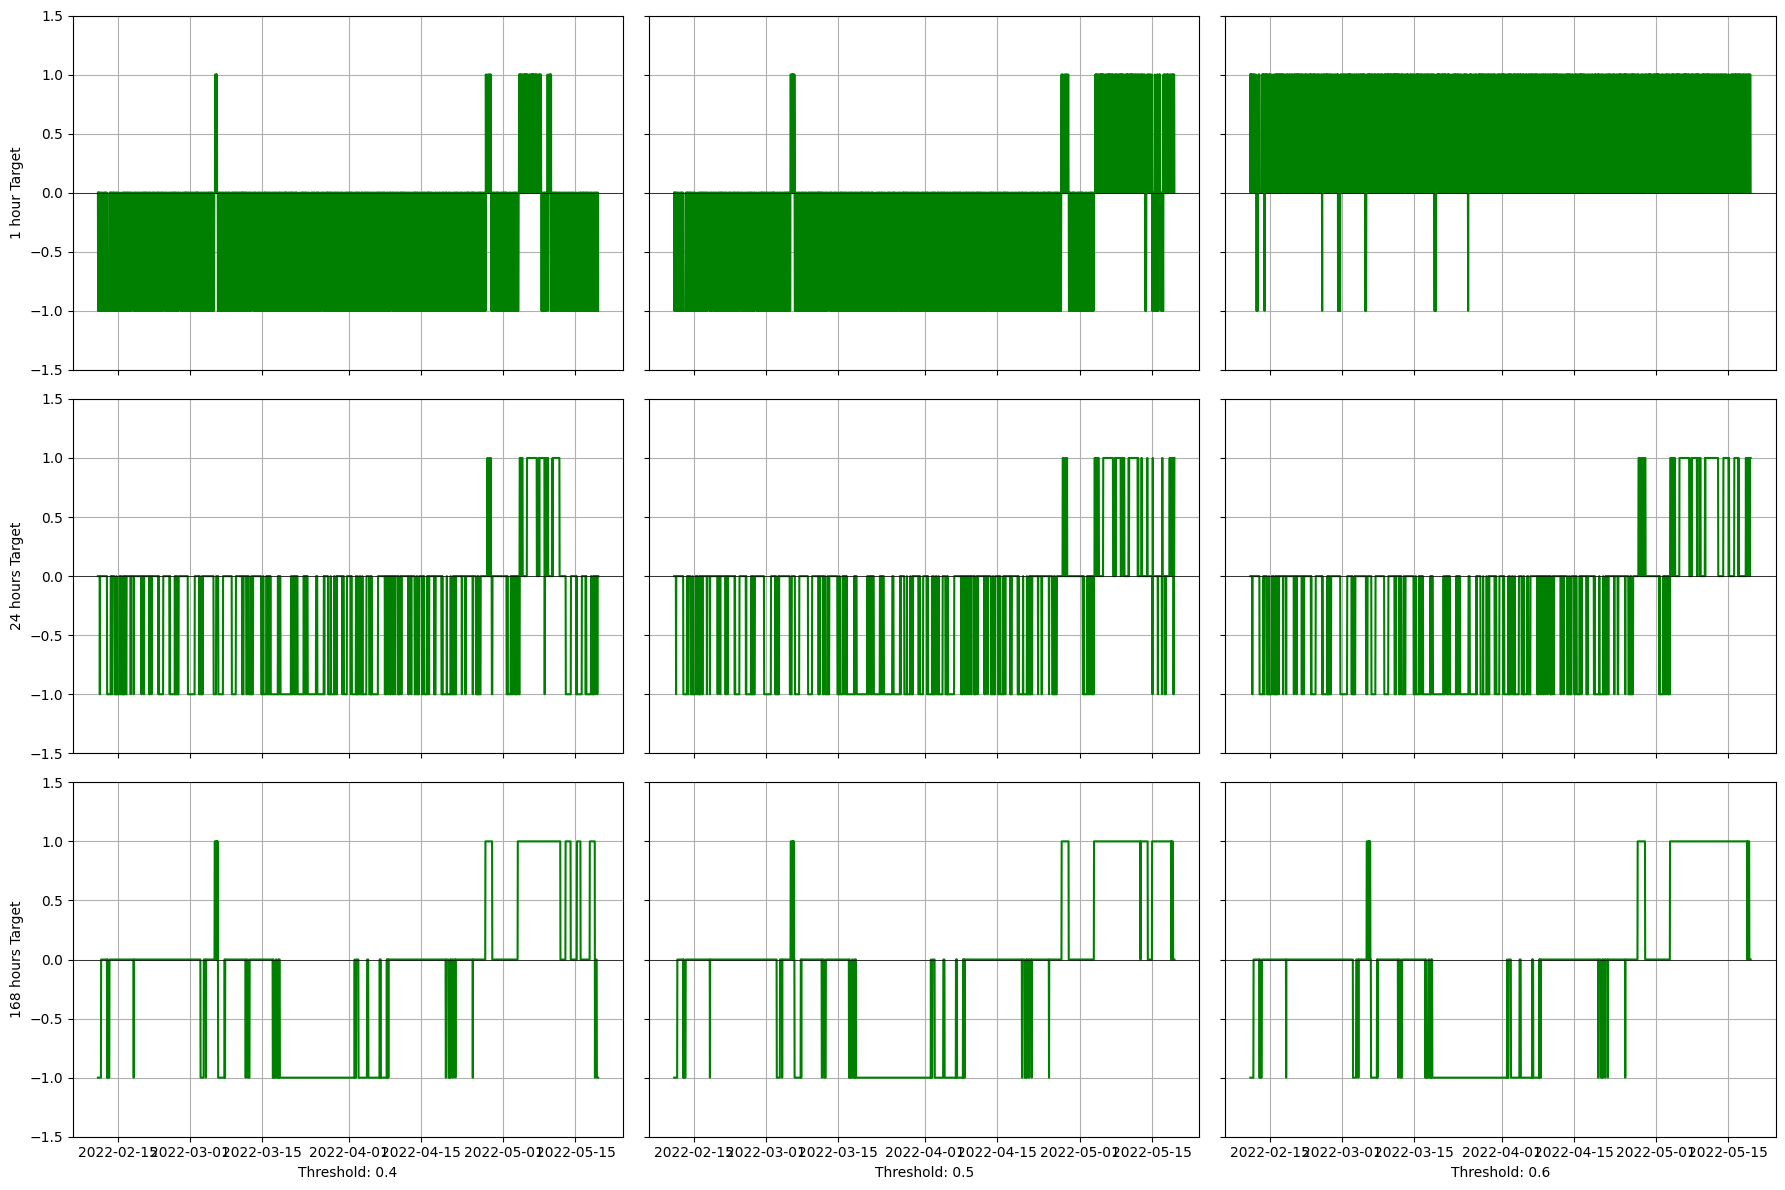

In [13]:

fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)

new_thresholds = [0.4, 0.5, 0.6]

for row, target in enumerate(targets):
    for col, thresh in enumerate(new_thresholds):
        ax = axes[row, col]
        actual_values = [act[row] for act in all_actual[-len(y_test):]]
        predicted_values = [pred[row] for pred in all_predictions[-len(y_test):]]
        predicted_labels = [(1 if p > thresh else 0) for p in predicted_values]
        errors = []
        for actual, predicted in zip(actual_values, predicted_labels):
            if actual == predicted:
                errors.append(0)
            elif actual == 0 and predicted == 1:
                errors.append(-1)
            else:
                errors.append(1)
        ax.plot(test_dates, errors, label="Error", color="green")
        if col == 0:
            ax.set_ylabel(f'{target} Target')
        if row == 2:
            ax.set_xlabel(f'Threshold: {thresh}')
        ax.axhline(0, color='black', linewidth=0.5) # Drawing the 0 line for clarity
        ax.set_ylim([-1.5, 1.5]) # Setting y-axis limits for clear visualization
        ax.grid(True)

# Tight layout to ensure no overlaps
plt.tight_layout()

plt.savefig(f'results/plots/{current_time}_errors.png')
plt.show()

[0.5, 0.3125, 0.203125]
[0.5, 0.6875, 0.40625]
1460
370
[array([0.55403431, 0.52871472, 0.50642123]), array([0.56229703, 0.56154051, 0.60022659]), array([0.56137813, 0.5617324 , 0.60911298]), array([0.56323807, 0.56109028, 0.61535339]), array([0.56280999, 0.55979496, 0.5940563 ]), array([0.56097957, 0.55961414, 0.60134477]), array([0.56295022, 0.5610054 , 0.61009831]), array([0.56277678, 0.56295022, 0.61729083]), array([0.55868047, 0.56397984, 0.63132159]), array([0.56229703, 0.56641917, 0.62574545])]
[array([0.51614266, 0.62539505, 0.61614538]), array([0.51529806, 0.61399302, 0.52661835]), array([0.51740955, 0.60301329, 0.5498447 ]), array([0.48427964, 0.58232073, 0.60347646]), array([0.51429   , 0.47300022, 0.38934449]), array([0.51614266, 0.58105384, 0.59840889]), array([0.51614266, 0.57303019, 0.54856419]), array([0.51867644, 0.57303019, 0.58742916]), array([0.51023049, 0.59161127, 0.60305416]), array([0.51445347, 0.58063154, 0.57771632])]
10
10


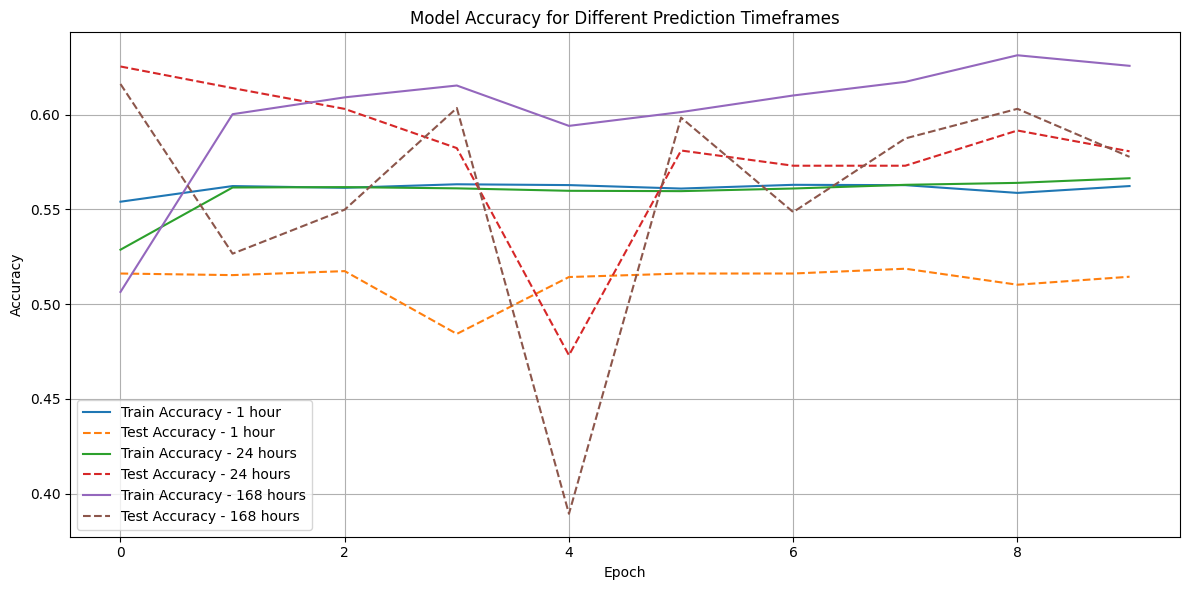

In [25]:

plt.figure(figsize=(12, 6))
a,b=[],[]

step_train = int(len(train_accuracies) / num_epochs)
step_test = int(len(test_accuracies)/num_epochs)
a = [np.mean(train_accuracies[i:i+step_train], axis=0) for i in range(0, len(train_accuracies), step_train)]
b = [np.mean(test_accuracies[i:i+step_test], axis=0) for i in range(0, len(test_accuracies), step_test)]

for idx, target in enumerate(targets):
    plt.plot(range(num_epochs), [acc[idx] for acc in a], label=f"Train Accuracy - {target}")
    plt.plot(range(num_epochs), [acc[idx] for acc in b], label=f"Test Accuracy - {target}", linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy for Different Prediction Timeframes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'results/plots/{current_time}_accuracy.png')
plt.show()

In [28]:

final_test_acc = calculate_accuracy(tensor(all_predictions[int(len(all_predictions)/num_epochs*(num_epochs - 1)):]), y_test)
for idx, target in enumerate(targets):
    print(f"Final Test Accuracy for {target}: {final_test_acc[idx]*100:.2f}%")

Final Test Accuracy for 1 hour: 51.31%
Final Test Accuracy for 24 hours: 57.52%
Final Test Accuracy for 168 hours: 57.86%
